In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm 
from sklearn.utils import shuffle
import random
%matplotlib inline
import torch.nn as nn
from my_utils import np_norm_decoder
import torch.nn.functional as F
import os
# plt.style.use('dark_background')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 10
def set_seed(seed):
    print("Set Seed to",seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device

device(type='cuda')

In [2]:
met_abs = pd.read_csv('/home/sym/ASPACC BSS/data/1311/methane_abs.csv', delimiter=',', header=None, skiprows=2).to_numpy()
eth_abs = pd.read_csv('/home/sym/ASPACC BSS/data/1311/ethane_abs.csv', delimiter=',', header=None, skiprows=2).to_numpy()
ethy_abs = pd.read_csv('/home/sym/ASPACC BSS/data/1311/ethylene_abs.csv', delimiter=',', header=None, skiprows=2).to_numpy()
prop_abs = pd.read_csv('/home/sym/ASPACC BSS/data/1311/propyne_abs.csv', delimiter=',', header=None, skiprows=2).to_numpy()
v=np.linspace(2989.5, 2984.5, len(met_abs))

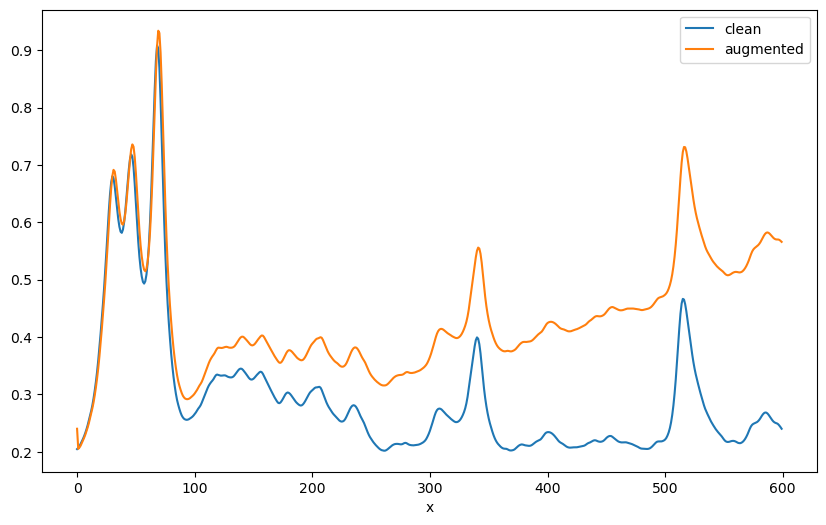

In [4]:
import numpy as np


import numpy as np

def augment_signals_nonlinear(dataset,
                              noise_frac=0.0,
                              baseline_frac=0.0,
                              max_shift=0):
    """
    dataset: array (N, L) of clean signals
    returns:
      features: array (N, L+3) where columns are
        [0:L]      = augmented spectrum
        [L]        = shift (int)
        [L+1]      = quadratic coeff a
        [L+2]      = linear coeff  b
    """
    N, L = dataset.shape
    σ = noise_frac    * np.std(dataset, axis=None)
    baseline_max = baseline_frac * np.max(dataset, axis=None)
    t = np.linspace(0, 1, L)

    features = np.zeros((N, L + 3), dtype=dataset.dtype)

    for i in range(N):
        clean = dataset[i].copy()

        # 1) random shift
        shift = np.random.randint(-max_shift, max_shift + 1)
        aug = np.roll(clean, shift)

        # 2) baseline drift (quadratic + linear only)
        a = np.random.uniform(-baseline_max, baseline_max)
        b = np.random.uniform(-baseline_max, baseline_max)
        baseline = a * t**2 + b * t
        aug = aug + baseline

        # 3) additive noise
        noise = np.random.randn(L) * σ
        aug = aug + noise

        # pack
        features[i, :L]   = aug
        features[i,   L]  = shift
        features[i, L+1]  = a
        features[i, L+2]  = b

    return features
# --- Usage example ---
Nobs = 1000
Con = np.zeros([int(Nobs),4])
Con[:,0] = np.random.random([int(Nobs)])
Con[:,1] = np.random.random([int(Nobs)])
Con[:,2] = np.random.random([int(Nobs)])
Con[:,3] = np.random.random([int(Nobs)])

dataset_clean=np.matmul(Con,[met_abs[:,4], eth_abs[:,4],ethy_abs[:,4]/2,prop_abs[:,4]]) #,df1[9] ,df1[10]]

dataset_aug = augment_signals_nonlinear(dataset_clean,
                                        noise_frac=0.0,
                                        baseline_frac=0.2,
                                        max_shift=3)

# Plot an example
plt.figure(figsize=(10,6))
plt.plot(dataset_clean[59], label="clean")
plt.plot(dataset_aug[59,:600],  label="augmented")
plt.xlabel("x")
plt.legend()
plt.show()


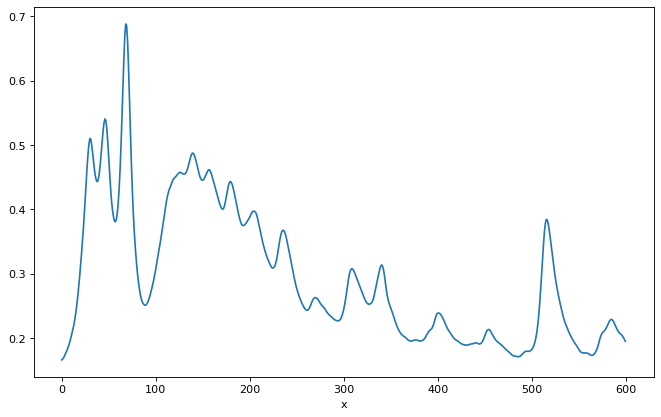

In [5]:
Nobs=10000
Con = np.zeros([int(Nobs),4])
Con[:,0] = np.random.random([int(Nobs)])
Con[:,1] = np.random.random([int(Nobs)])
Con[:,2] = np.random.random([int(Nobs)])
Con[:,3] = np.random.random([int(Nobs)])
plt.style.use('default')
Con[:,3] = np.random.random([int(Nobs)])
dataset_clean=np.matmul(Con,[met_abs[:,4], eth_abs[:,4] ,ethy_abs[:,4]/2, prop_abs[:,4]]) #,df1[9] ,df1[10]]
fig = plt.figure(figsize=(10, 6), dpi=80)
plt.plot(dataset_clean[5,:])
plt.xlabel('x')

Con2=np.copy(Con)

In [7]:
paired_signals_2=augment_signals_nonlinear(dataset_clean, noise_frac=0.1,
                                        baseline_frac=0.2,
                                        max_shift=5)

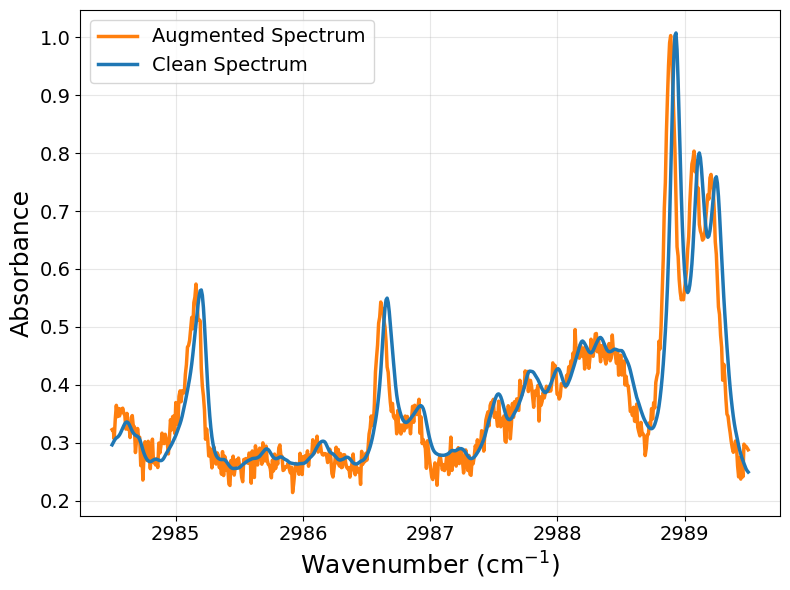

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Example placeholders (replace with real data)
# v = np.linspace(2989.5, 2984.5, 600)
# paired_signals_2 = np.random.randn(200, 600)
# dataset_clean = np.random.randn(200, 600)

plt.figure(figsize=(8, 6))

plt.plot(v, paired_signals_2[100, :600], label='Augmented Spectrum', linewidth=2.5, color='tab:orange')
plt.plot(v, dataset_clean[100], label='Clean Spectrum', linewidth=2.5, color='tab:blue')

plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=18)
plt.ylabel('Absorbance', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, which='both', alpha=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
# plt.savefig('/home/sym/ASPACC BSS/plots/noisy_clean.pdf', transparent=True, dpi=300)
# plt.savefig('/home/sym/ASPACC BSS/plots/noisy_clean.png', transparent=True, dpi=150)
plt.show()
plt.show()


In [23]:
# leanring parameters
epochs =500
batch_size = 128
lr = 0.001

# Reshaping data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Spec_T = torch.tensor(paired_signals_2)
Con_T = torch.tensor(Con)

train_features = Spec_T[:int(Nobs*1)]      #60% of df
val_features   = Spec_T[int(Nobs*0.9):int(Nobs)]#20% of df
test_features  = Spec_T[int(Nobs*0.9):int(Nobs)]#20% of df

train_targets = Con_T[:int(Nobs*1)]      #60% of df
val_targets   = Con_T[int(Nobs*0.9):int(Nobs)]#20% of df
test_targets  = Con_T[int(Nobs*0.9):int(Nobs)]#20% of df

train = torch.utils.data.TensorDataset(torch.Tensor(np.array(train_features)).to(device), torch.Tensor(np.array(train_targets)).to(device))
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

val = torch.utils.data.TensorDataset(torch.Tensor(np.array(val_features)).to(device), torch.Tensor(np.array(val_targets)).to(device))
valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size)

test = torch.utils.data.TensorDataset(torch.Tensor(np.array(test_features)).to(device), torch.Tensor(np.array(test_targets)).to(device))
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size)

In [10]:
import torch
import torch.nn as nn

# Convert the Pandas Series to PyTorch tensors and then squeeze them to get the correct shape
CH4_tensor = torch.tensor(met_abs[:,1]).float().squeeze()
C2H6_tensor = torch.tensor(eth_abs[:,1]).float().squeeze()
C2H4_tensor = torch.tensor(ethy_abs[:,1]/2).float().squeeze()
C3H4_tensor = torch.tensor(prop_abs[:,1]).float().squeeze()

# Stack the tensors along a new dimension to create a tensor of shape [3, 602]
stacked_tensors = torch.stack([CH4_tensor, C2H6_tensor, C2H4_tensor, C3H4_tensor], dim=0)
#, C2H6_tensor, C3H4_tensor],
# Create the parameter
# self.r = nn.Parameter(stacked_tensors, requires_grad=True)

shape1=np.shape(met_abs)
noise=torch.rand((4, shape1[0]))

In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dims=4):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 128, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv4 = nn.Conv1d(128, 64, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2, 2)
        self.conv5 = nn.Conv1d(64, 32, 5, padding=2)
        self.bn5 = nn.BatchNorm1d(32)
        self.pool3 = nn.MaxPool1d(2, 2)
        self.conv6 = nn.Conv1d(32, 16, 5, padding=2)
        self.bn6 = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(p=0.2)
        self.inter = nn.Linear(12 * 100, 18)  # intermediate fc layer
        self.linear2 = nn.Linear(18, latent_dims)  # intermediate fc layer

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = F.relu(self.bn6(self.conv6(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.inter(x)
        z = self.linear2(x)
        if (z.max(axis=0).values - z.min(axis=0).values)[0] != 0 and (z.max(axis=0).values - z.min(axis=0).values)[1] != 0:
            z = (z - z.min(axis=0).values) / (z.max(axis=0).values - z.min(axis=0).values)
        return z
shape1=np.shape(met_abs)
latent_dims=4
class Decoder(nn.Module):
    def __init__(self, latent_dims=latent_dims):
        super(Decoder, self).__init__()
        self.r = nn.Parameter(stacked_tensors, requires_grad=True)
        # self.r = nn.Parameter(noise, requires_grad=True)

    def forward(self, z):
        x=torch.matmul(z,self.r)
        return z,x
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
import pandas as pd

def train(autoencoder, train_loader, valid_loader, epochs=500):
    losses = {'train': [], 'validation': []}
    valid_loss_min = np.Inf
    opt = torch.optim.Adam(autoencoder.parameters(), lr=1e-2)

    r_values = []  # List to store self.r values at each epoch
    x_hat_values = []  # List to store x_hat values at each epoch

    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        autoencoder.train()

        for x, y in train_loader:
            x = x.to(device)
            opt.zero_grad()

            # Real data reconstruction
            z, x_hat = autoencoder(x)
            reconstruction_loss = ((x - x_hat)**2).sum()

            # Synthetic loss
            z_synth, x_hat_synth = autoencoder(x_hat)
            synthetic_loss = ((z_synth - z)**2).sum()
            
            # Total loss: combine real and synthetic losses
            loss = reconstruction_loss + 1 * synthetic_loss
            loss.backward()
            opt.step()
            train_loss += loss.item() * x.size(0)

        autoencoder.eval()
        for x, y in valid_loader:
            x = x.to(device)
            with torch.no_grad():
                z, x_hat = autoencoder(x)
                reconstruction_loss = ((x - x_hat)**2).sum()
                
                z_synth, x_hat_synth = autoencoder(x_hat)
                synthetic_loss = ((z_synth - z)**2).sum()
                
                loss = reconstruction_loss + 1 * synthetic_loss
                valid_loss += loss.item() * x.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        losses['train'].append(train_loss)
        losses['validation'].append(valid_loss)

        # Save self.r values and x_hat at each epoch
        r_values.append(autoencoder.decoder.r.clone().detach().cpu().numpy())
        x_hat_values.append(x_hat.clone().detach().cpu().numpy())

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                  valid_loss_min, valid_loss))
            valid_loss_min = valid_loss

    # Save losses to a CSV file
    loss_df = pd.DataFrame(losses)
    loss_df.to_csv("training_losses3.csv", index=False)

    # Convert the lists to numpy arrays
    r_values = np.array(r_values)
    x_hat_values = np.array(x_hat_values)

    return autoencoder, r_values, x_hat_values


In [13]:
latent_dims = 4
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder, r_values, x_hat_values= train(autoencoder, train_loader,valid_loader,500)

Epoch: 0 	Training Loss: 3209.540373 	Validation Loss: 1439.842758
Validation loss decreased (inf --> 1439.842758).  Saving model ...
Epoch: 1 	Training Loss: 600.648279 	Validation Loss: 282.397620
Validation loss decreased (1439.842758 --> 282.397620).  Saving model ...
Epoch: 2 	Training Loss: 278.120475 	Validation Loss: 145.653612
Validation loss decreased (282.397620 --> 145.653612).  Saving model ...
Epoch: 3 	Training Loss: 182.643821 	Validation Loss: 118.404913
Validation loss decreased (145.653612 --> 118.404913).  Saving model ...
Epoch: 4 	Training Loss: 139.643491 	Validation Loss: 134.499000
Epoch: 5 	Training Loss: 138.140317 	Validation Loss: 102.482797
Validation loss decreased (118.404913 --> 102.482797).  Saving model ...
Epoch: 6 	Training Loss: 125.898723 	Validation Loss: 82.299940
Validation loss decreased (102.482797 --> 82.299940).  Saving model ...
Epoch: 7 	Training Loss: 115.196885 	Validation Loss: 84.928604
Epoch: 8 	Training Loss: 108.158911 	Validation 

In [14]:
spectras=autoencoder.decoder.r.clone().detach().cpu().numpy()
spectras[spectras<0]=0
filtered_2 =[spectras[0],spectras[1]]
filtered_2= pd.DataFrame(filtered_2)
# filtered_2.to_csv('filtered_new_2.csv',index=False)

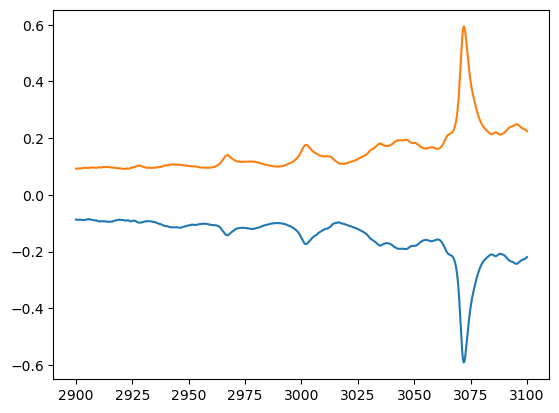

In [15]:
v = np.linspace(2900, 3100, 600)  # Example x-values
# df2=[df1[2] , df1[1]]
plt.plot(v,-spectras[3])
# plt.plot(v,spectras[3]/2.2)
# spectras[3]=spectras
plt.plot(v,prop_abs[:,4])

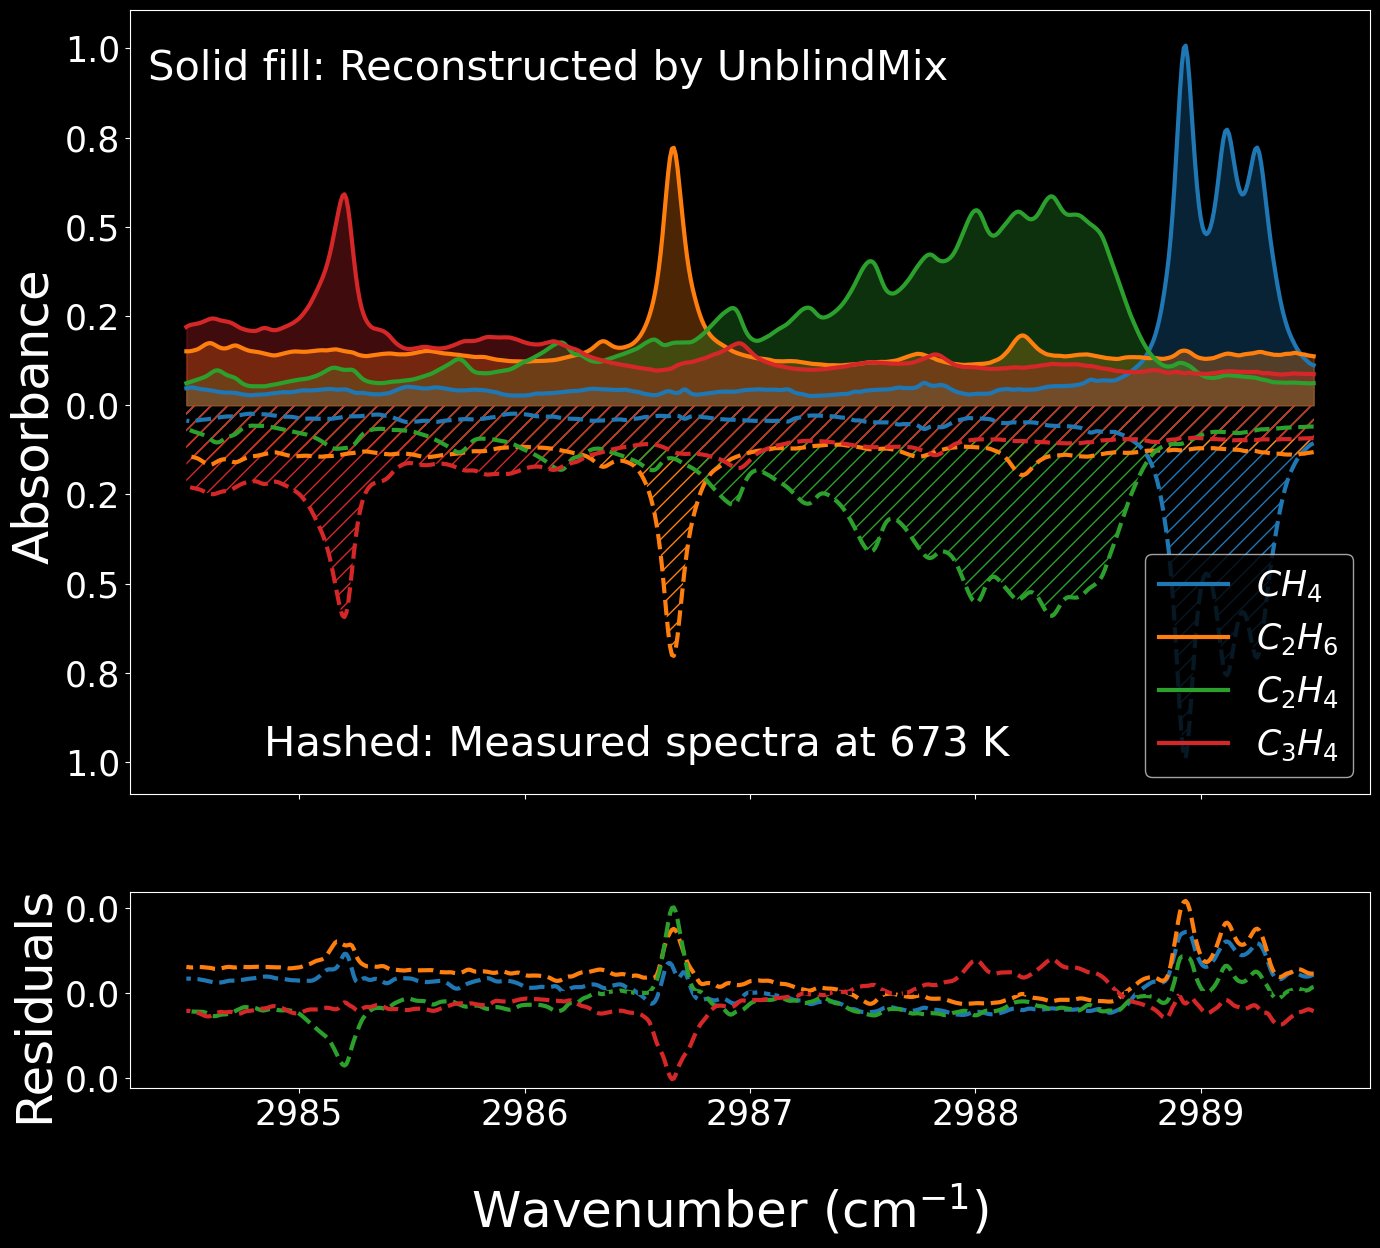

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter


Exper = [-met_abs[:,4], -eth_abs[:,4], -ethy_abs[:,4]/2,-prop_abs[:,4]]

species = ['$CH_4$', '$C_2H_6$', '$C_2H_4$', '$C_3H_4$']

v = np.linspace(2989.5, 2984.5, 600)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Define colors for each species

fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# Plotting spectras_updated and Exper with filled areas
for i in range(4):
    axes[0].plot(v, spectras[i], label=f'{species[i]}', color=colors[i], linewidth=3)
    axes[0].fill_between(v, 0, spectras[i], color=colors[i], alpha=0.3)
    axes[0].plot(v, Exper[i], color=colors[i], linestyle='--', linewidth=3)
    axes[0].fill_between(v, 0, Exper[i], facecolor='none', edgecolor=colors[i], hatch='//', linewidth=0.0)

# Adding the text inside the first subplot at the top
axes[0].text(0.66, 0.95, 'Solid fill: Reconstructed by UnblindMix', 
             verticalalignment='top', horizontalalignment='right', 
             transform=axes[0].transAxes, fontsize=30)

axes[0].tick_params(axis='both', which='major', labelsize=25)
axes[0].legend(fontsize=25, loc='lower right', ncol=1, bbox_to_anchor=(1, 0))

# Plotting residuals with hashed pattern
for i in range(4):
    residuals = spectras[i] + Exper[i]
    weighted_error = np.sum((residuals)) / np.sum(np.abs(Exper[i])) * 100
    axes[1].plot(v, residuals, linestyle='--', linewidth=3, label=f'Residuals - {species[i]} (Weighted Error: {weighted_error:.2f}%)', color=colors[i])

axes[1].axhline(y=0, color='black', linestyle=':', linewidth=3)  # Add horizontal line at y=0 for reference
axes[1].tick_params(axis='both', which='major', labelsize=25)

axes[1].text(0.72, 1.65, 'Hashed: Measured spectra at 673 K ', 
             verticalalignment='bottom', horizontalalignment='right', 
             transform=axes[1].transAxes, fontsize=30)

for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(abs(x))))

# Set common x and y labels for the entire figure
fig.text(0.5, 0.01, 'Wavenumber (cm$^{-1}$)', ha='center', fontsize=36)
fig.text(0.05, 0.59, 'Absorbance', va='center', rotation='vertical', fontsize=36)
fig.text(0.05, 0.17, 'Residuals', va='center', rotation='vertical', fontsize=36)
plt.style.use('dark_background')

# Save the figure if needed
# plt.savefig('/home/sym/ASPACC BSS/plots/results_673_dark.pdf', transparent=True, dpi=300)
# plt.savefig('/home/sym/ASPACC BSS/plots/results_673_dark.png', transparent=True, dpi=150)
# # plt.savefig('/home/sym/BSS/paper_figures/experiments/exp_recons_filled_dark.pdf', transparent=True, dpi=600)
plt.show()


## NMF

In [18]:
import numpy as np
from sklearn.decomposition import NMF

# 1) Your non-negative data matrix (Nobs × n_features)
X = paired_signals_2[:1000, :600]         # e.g. first 602 cols
X_nonneg = X - X.min()           # shift into >=0

# 2) Your H_init from the spectra (n_components × n_features)
H_init = stacked_tensors.cpu().numpy().astype(np.float64)  # shape (4, 602)
H_init = np.clip(H_init, 0, None)                          # ensure non-neg

n_samples, n_features = X_nonneg.shape
n_components = H_init.shape[0]

# 3) Make a random non-negative W_init
rng = np.random.default_rng(seed=0)
W_init = rng.random((n_samples, n_components), dtype=np.float64)

# 4) Build the NMF model with custom init
model = NMF(
    n_components=n_components,
    init='custom',
    tol=1e-5,
    max_iter=1000,
    random_state=0
)

# 5) Pass both W_init and H_init to fit_transform
W = model.fit_transform(X_nonneg, W=W_init, H=H_init)
H = model.components_

print("W shape:", W.shape)  # (Nobs, 4)
print("H shape:", H.shape)  # (4, 602)


W shape: (1000, 4)
H shape: (4, 600)


/sw/rl9g/machine_learning/2024.01/rl9_cudnn8_cuda11.8_py3.9_env/machine_learning-module/env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


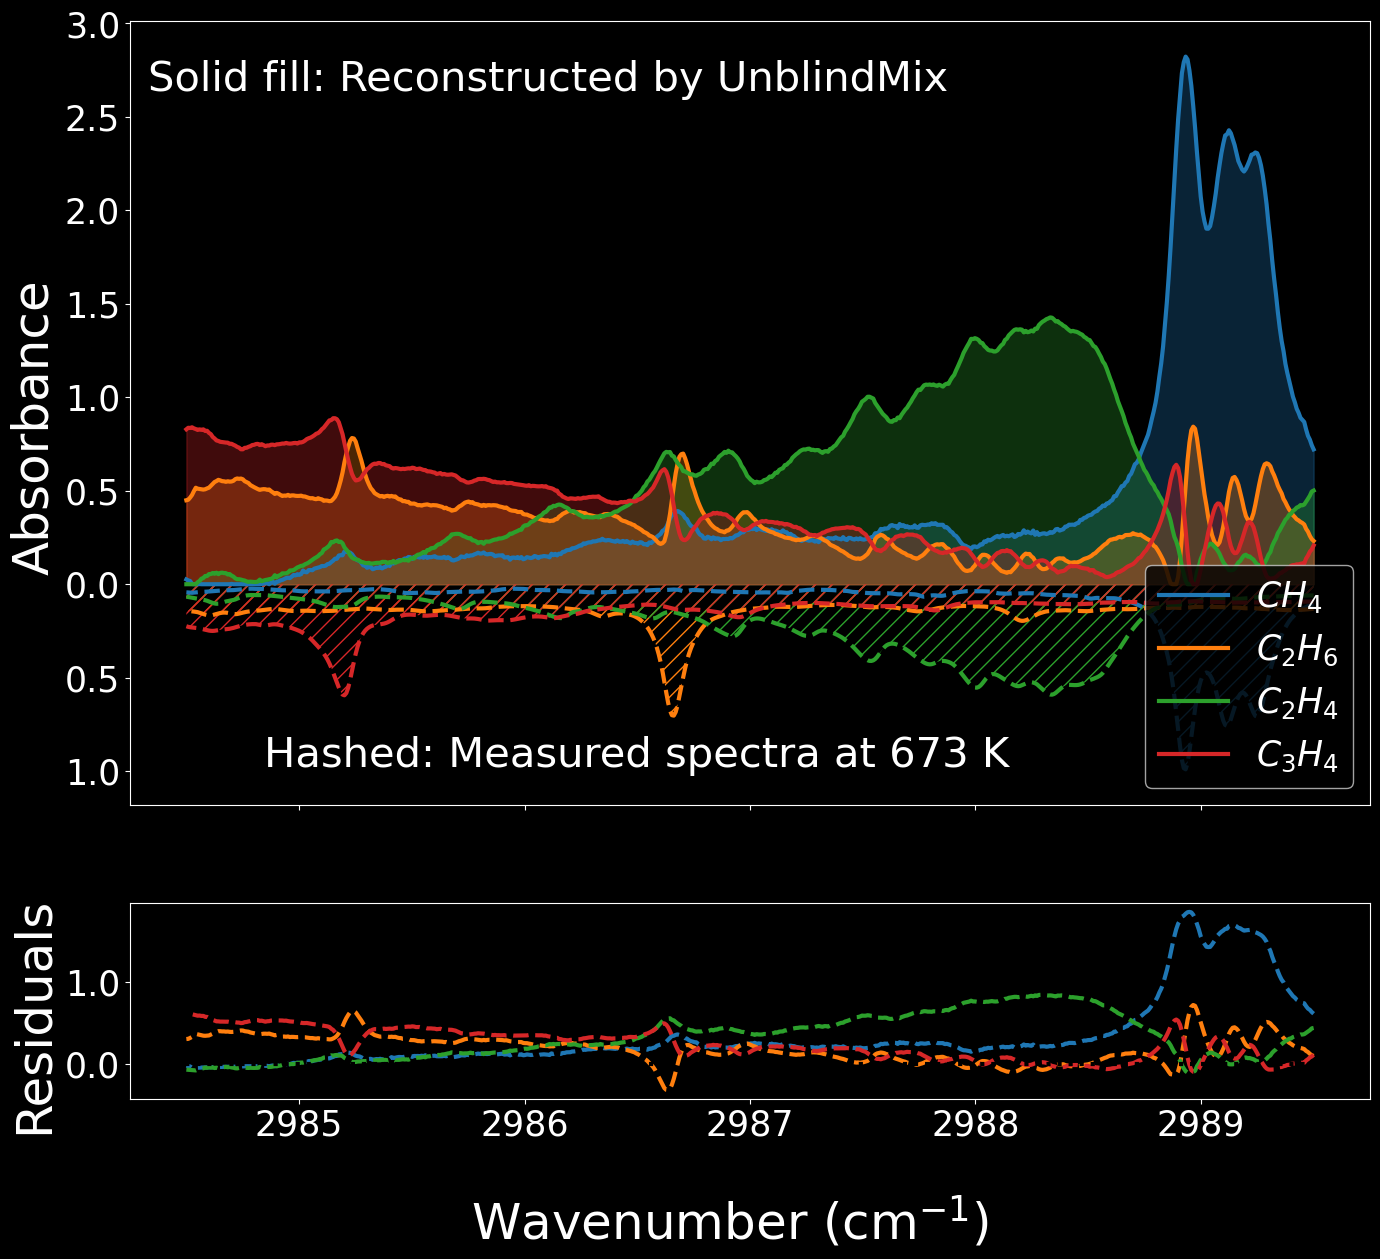

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Assuming 'spectras_updated', '-CH4', '-C2H6', '-C2H4', '-C3H4' are defined elsewhere in your code

# spectras_updated = [spectras[0], spectras[2], spectras[3], spectras[1]]
Exper = [-met_abs[:,4], -eth_abs[:,4], -ethy_abs[:,4]/2,-prop_abs[:,4]]

species = ['$CH_4$', '$C_2H_6$', '$C_2H_4$', '$C_3H_4$']

v = np.linspace(2989.5, 2984.5, 600)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Define colors for each species

fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# Plotting spectras_updated and Exper with filled areas
for i in range(4):
    axes[0].plot(v, H[i], label=f'{species[i]}', color=colors[i], linewidth=3)
    axes[0].fill_between(v, 0, H[i], color=colors[i], alpha=0.3)
    axes[0].plot(v, Exper[i], color=colors[i], linestyle='--', linewidth=3)
    axes[0].fill_between(v, 0, Exper[i], facecolor='none', edgecolor=colors[i], hatch='//', linewidth=0.0)

# Adding the text inside the first subplot at the top
axes[0].text(0.66, 0.95, 'Solid fill: Reconstructed by UnblindMix', 
             verticalalignment='top', horizontalalignment='right', 
             transform=axes[0].transAxes, fontsize=30)

axes[0].tick_params(axis='both', which='major', labelsize=25)
axes[0].legend(fontsize=25, loc='lower right', ncol=1, bbox_to_anchor=(1, 0))

# Plotting residuals with hashed pattern
for i in range(4):
    residuals = H[i] + Exper[i]
    weighted_error = np.sum((residuals)) / np.sum(np.abs(Exper[i])) * 100
    axes[1].plot(v, residuals, linestyle='--', linewidth=3, label=f'Residuals - {species[i]} (Weighted Error: {weighted_error:.2f}%)', color=colors[i])

axes[1].axhline(y=0, color='black', linestyle=':', linewidth=3)  # Add horizontal line at y=0 for reference
axes[1].tick_params(axis='both', which='major', labelsize=25)

axes[1].text(0.72, 1.65, 'Hashed: Measured spectra at 673 K ', 
             verticalalignment='bottom', horizontalalignment='right', 
             transform=axes[1].transAxes, fontsize=30)

for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}'.format(abs(x))))

# Set common x and y labels for the entire figure
fig.text(0.5, 0.01, 'Wavenumber (cm$^{-1}$)', ha='center', fontsize=36)
fig.text(0.05, 0.59, 'Absorbance', va='center', rotation='vertical', fontsize=36)
fig.text(0.05, 0.17, 'Residuals', va='center', rotation='vertical', fontsize=36)

# Adjust layout to ensure there is no overlap
# # plt.tight_layout(rect=[0.04, 0.04, 1, 1])
# plt.style.use('default')
# plt.style.use('default')
plt.style.use('dark_background')

plt.show()
